In [8]:
import geopandas as gpd
import numpy as np
from shapely import geometry

from lausanne_greening_scenarios import utils

In [7]:
def sector(center, start_angle, end_angle, radius, steps=200):
    # https://bit.ly/2BXKNwz
    def polar_point(origin_point, angle,  distance):
        return [origin_point.x + np.sin(np.radians(angle)) * distance, origin_point.y + np.cos(np.radians(angle)) * distance]

    if start_angle > end_angle:
        start_angle = start_angle - 360
    else:
        pass
    step_angle_width = (end_angle-start_angle) / steps
    sector_width = (end_angle-start_angle) 
    segment_vertices = []

    segment_vertices.append(polar_point(center, 0,0))
    segment_vertices.append(polar_point(center, start_angle,radius))

    for z in range(1, steps):
        segment_vertices.append((polar_point(center, start_angle + z * step_angle_width,radius)))
    segment_vertices.append(polar_point(center, start_angle+sector_width,radius))
    segment_vertices.append(polar_point(center, 0,0))
    return geometry.Polygon(segment_vertices)

In [6]:
base_mask = utils.BASE_MASK
base_mask_gser = gpd.GeoSeries(base_mask, crs=utils.BASE_MASK_CRS)
avg_longitude = base_mask_gser.to_crs(
    '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'
).unary_union.centroid.x
# trick from OSMnx to be able to buffer in meters
utm_zone = int(np.floor((avg_longitude + 180) / 6.) + 1)
utm_crs = {
    'datum': 'WGS84',
    'ellps': 'WGS84',
    'proj': 'utm',
    'zone': utm_zone,
    'units': 'm'
}
base_mask_geom = base_mask_gser.to_crs(utm_crs).iloc[0]


In [15]:
num_angles = 12
num_rings = 8
end_radius = 14000

In [16]:
angle_delta = 360 / num_angles

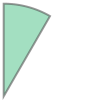

In [10]:
angle_delta = 360 / num_angles

geoms = []
for i in range(num_angles):
    start_angle = i * angle_delta
    geoms.append(sector(base_mask_geom, start_angle, start_angle + angle_delta, ))

In [ ]:
base_mask_gser = gpd.GeoSeries(base_mask, crs=base_mask_crs)

# 3. buffer around base mask
avg_longitude = base_mask_gser.to_crs(
    '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs').unary_union.centroid.x
# trick from OSMnx to be able to buffer in meters
utm_zone = int(np.floor((avg_longitude + 180) / 6.) + 1)
utm_crs = {
    'datum': 'WGS84',
    'ellps': 'WGS84',
    'proj': 'utm',
    'zone': utm_zone,
    'units': 'm'
}
base_mask_geom = base_mask_gser.to_crs(utm_crs).iloc[0]

_buffer_dists = np.concatenate([[0], buffer_dists])
buffer_dists = list(
    map(lambda d: '{}-{}'.format(d[0], d[1]),
        zip(_buffer_dists[:-1], _buffer_dists[1:])))
masks_gser = gpd.GeoSeries([
    base_mask_geom.buffer(_buffer_dists[i + 1]) -
    base_mask_geom.buffer(_buffer_dists[i])
    for i in range(len(_buffer_dists) - 1)
],
                           index=buffer_dists,
                           crs=utm_crs).to_crs(landscape_crs)